<a href="https://colab.research.google.com/github/Eatosin/PolyMind-Crypto-Arbitrage/blob/main/PolyMind_Arbitrage_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print("🏦 Initializing PolyMind Market Simulator (Hard Mode)...")

def generate_toxic_market_data(n_samples=5000):
    np.random.seed(42) # Consistent chaos

    # 1. Generate Basic Features
    # Spread: Most are small, some are huge (exponential)
    spread = np.random.exponential(scale=0.03, size=n_samples)

    # Liquidity: Random depth
    liquidity = np.random.uniform(500, 100000, n_samples)

    # Volatility: 0 to 1
    volatility = np.random.beta(2, 5, n_samples)

    trade_success = []

    # 2. Apply The "Toxic Trap" Logic
    for i in range(n_samples):
        s = spread[i] * 100 # Cents
        l = liquidity[i]
        v = volatility[i]

        # --- THE TRAP ---
        # If Spread is HUGE (>4c) but Liquidity is LOW (<$5000),
        # it is a "Fake Order." You will get slipped and lose money.
        if s > 4.0 and l < 5000:
            outcome = 0 # FAIL

        # --- THE GOLDEN TICKET ---
        # High Spread + High Liquidity = Profit
        elif s > 2.0 and l > 20000 and v < 0.5:
            outcome = 1 # SUCCESS

        # --- RANDOM NOISE ---
        else:
            # Random chance based on conditions
            prob = (l / 100000) - (v * 0.5)
            outcome = 1 if np.random.rand() < prob else 0

        trade_success.append(outcome)

    # Create DataFrame
    df = pd.DataFrame({
        "spread_cents": spread * 100,
        "liquidity_usd": liquidity,
        "volatility_index": volatility,
        "trade_success": np.array(trade_success)
    })

    return df

# Generate Data
data = generate_toxic_market_data(5000)
print(f"✅ Generated {len(data)} trade scenarios with Liquidity Traps.")

🏦 Initializing PolyMind Market Simulator (Hard Mode)...
✅ Generated 5000 trade scenarios with Liquidity Traps.


🧠 Training Execution Model...
🚀 AI Trained. Accuracy in predicting failure: 86.70%


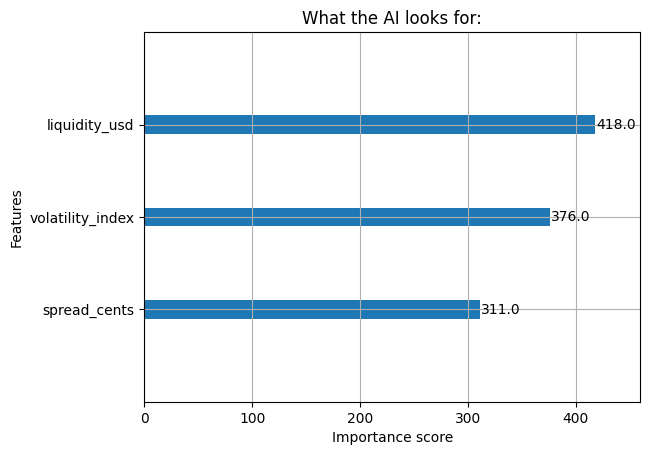

In [16]:
print("🧠 Training Execution Model...")

# Split Data
X = data[["spread_cents", "liquidity_usd", "volatility_index"]]
y = data["trade_success"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost
model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)
model.fit(X_train, y_train)

# Check Accuracy
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"🚀 AI Trained. Accuracy in predicting failure: {acc*100:.2f}%")

# Visualize what the AI learned (Should prioritize Liquidity/Spread)
xgb.plot_importance(model)
plt.title("What the AI looks for:")
plt.show()

⚔️ STARTING LIVE BACKTEST: AI vs. NAIVE BOT...


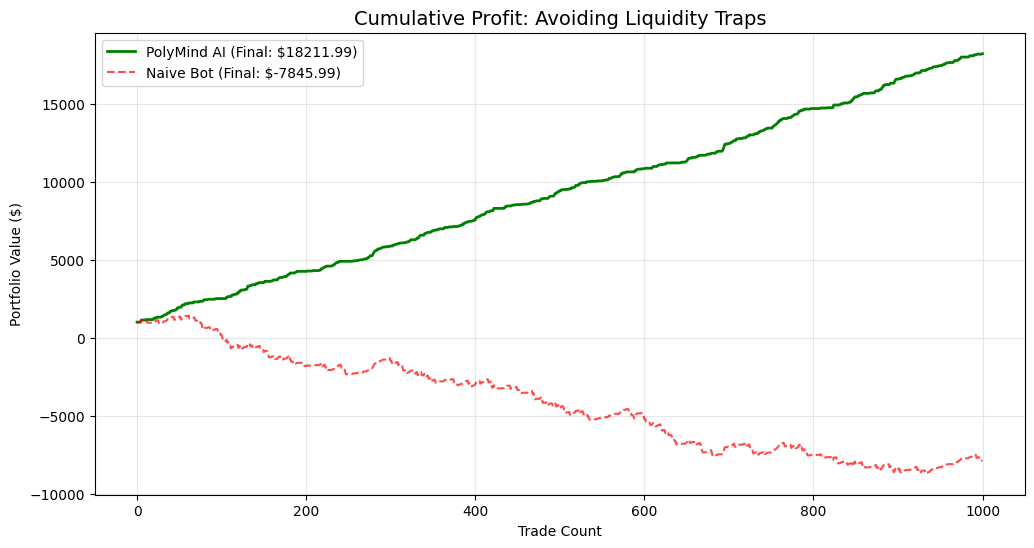

🏆 AI Edge: $26057.98 difference.


In [17]:
print("⚔️ STARTING LIVE BACKTEST: AI vs. NAIVE BOT...")

test_data = X_test.copy()
test_data['actual_outcome'] = y_test
# Get the AI's confidence score (0 to 1)
test_data['ai_confidence'] = model.predict_proba(X_test)[:, 1]

balance_ai = 1000
balance_naive = 1000
history_ai = [1000]
history_naive = [1000]

trade_log = []

for index, row in test_data.iterrows():
    spread = row['spread_cents']

    # --- NAIVE STRATEGY (Greedy) ---
    # "If spread is > 2 cents, BUY!"
    if spread > 2.0:
        if row['actual_outcome'] == 1:
            profit = (spread / 100) * 1000
            balance_naive += profit
        else:
            # FAILURE: Massive Slippage penalty
            loss = 200 # Fixed $200 loss per bad trade
            balance_naive -= loss

    # --- POLYMIND AI STRATEGY (Smart) ---
    # "Only buy if AI is 90% sure it's not a trap"
    if spread > 2.0 and row['ai_confidence'] > 0.90:
        if row['actual_outcome'] == 1:
            profit = (spread / 100) * 1000
            balance_ai += profit
        else:
            loss = 200
            balance_ai -= loss

    history_ai.append(balance_ai)
    history_naive.append(balance_naive)

# --- VISUAL PROOF ---
plt.figure(figsize=(12, 6))
plt.plot(history_ai, label=f'PolyMind AI (Final: ${balance_ai:.2f})', color='green', linewidth=2)
plt.plot(history_naive, label=f'Naive Bot (Final: ${balance_naive:.2f})', color='red', linestyle='--', alpha=0.7)
plt.title("Cumulative Profit: Avoiding Liquidity Traps", fontsize=14)
plt.xlabel("Trade Count")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"🏆 AI Edge: ${balance_ai - balance_naive:.2f} difference.")